# Quantifying Rpb1 blobs

A longstanding goal about all of our observations of transcription protein clustering is to quantify the number of proteins in the various structures we see. Rpb1 is ripe for this: it forms very clear, discrete, stable structures, and we have some very good biological hypotheses about what these structures are and what questions we can ask about them. We've been around theh ringer trying different things, but I had the idea of looking at MCP-GFP + MS2. The idea is that transcribed loci could act as standards: we have some estimate of the number of GFP molecules at these loci (it's not a very good estimate) and we could use these loci to extrapolate to the strength of our blobs.

I got flies from Nick and made a few movies, and had a surprise: I'm pretty certain I see individual MS2-labeled mRNAs in these movies. This has given me at least the beginning of a plan. These mRNAs give us standards with a much more accurate accounting of GFP number (we need only account for occupancy of the stem loops, instead of occupancy of stem loops as well as pol2 density at the transcribed loci). These particles are also happily in the range of the numbers of elongating polymerases we expect at early-transcribed loci. I need to check on the estimates, but I think the maximum occupancy is thought to be something like one every 30-50 bp which would be ~20-35 for a 1 kb gene, and early-transcribed genes are pretty short. Certainly on the same order of magnitude.

It's also worth pointing out that the presence of these guys gives us TWO standards: the individual mRNAs and the transcribed spot. We also have multiple MS2 constructs (including eveS2 constructs with variable lengths). One can imagine building standard curves from single mRNAs and various transcription spots. This method may not give us super-accurate absolute numbers, but it seems highly probably that we can at least situate the Rpb1 foci on that curve and get some crude estimates of molecule number, at least.

I did some reading about attempts to use standards (ratiometric quantitation). I'm not sure about those strategies, but they serve as some kind of guidelines. So what do I want to try to do?

First, I need to make some new movies. I've learned some things from looking through the movies I have:

- The best point for seeing single mRNAs is in the early cycles. Later on (nc14) they're too dense.
- The best time to see Rpb1 foci is also (of course) in the early cycles.
- I don't currently have well-matched samples, so I need samples collected with matched conditions.

Things I want to try for sample collection:

1. Collect matched movies of early cycles in Rpb1 and MCP-GFP+MS2.
2. Collect a laser-off image for background.
2. Try using higher laser power (better to see single mRNAs).
3. Image MCP-GFP with no MS2 to confirm that I don't see these particles that I think are MS2-labeled mRNAs.
4. Try my frozen trick again. Freeze some embryos, see if the single mRNAs are stabilized.

In [1]:
# Import public packages.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage as ndi 
from importlib import reload
import pickle
import czifile

# The order of loading matplotlib is important to avoid issues on my machine.
%matplotlib inline
import matplotlib as mpl
#%matplotlib notebook
#%matplotlib notebook

# Import my packages.
import sys
sys.path.append('/Users/michaelstadler/Bioinformatics/Projects/rpb1/bin')
import imagep as imp
reload(imp)
from imagep import viewer, save_pickle, load_pickle, box_spots, read_czi

## Analysis?

OK what about analysis? To start with, I'm just going to set up a thing where I click on spots. I can work on automatic detection later but not worth it currently. After detecting spots, I guess I need to draw shells and sum intensities. The papers I was looking at did this thing where they would define an inner region (say 5x5) that encompasses the spots and also a 7x7 region, subtracting the inner from the outer to give a "background". 

From Lawrimore, Bloom, and Salmon JCB 2011:

*Integrated fluorescence intensity (minus BG) measurements were ob- tained using the Hoffman et al. (2001) method as described in Joglekar et al. (2006) and Johnston et al. (2010). A 5 × 5 pixel region was centered on the fluorescent cluster or spot to obtain integrated fluores- cence, whereas a 7 × 7 region centered on the 5 × 5 region was used to obtain surrounding BG intensity. We only measured kinetochore clus- ters that did not obviously move. Measured values were calculated by: integrated fluorescence intensity (minus BG) = integrated counts for 5 × 5 region – (integrated counts for the 7 × 7 region  integrated counts for 5 × 5 region) × pixel area of the 5 × 5 region/(pixel area of the 7 × 7 region  pixel area of a 5 × 5 region). BG measurements were obtained from the 7 × 7 pixel region minus the value for the 5 × 5 pixel region and scaled to the same area as the specimen after subtracting the value for a camera image without laser illumination (mostly readout offset and noise). Note that each count (gray value in the 12 bit image) corresponds to approximately five photoelectrons.*

I wonder about, as an alernative, just collecting a box around all of the spots into a stack. Then I can make a composite using different metrics (mean, median, max, etc.) and compare to background (outer pixels). This might be more flexible.

Need to work on the click coordinates first:

In [2]:
stack= imp.read_czi('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/ratio-rpb1-20200731-rpb1Sna-rd2-em1-zs-02.czi', swapaxes=False)

In [9]:
b

{(8, 217, 155), (8, 645, 91), (8, 836, 217), (8, 977, 226), (8, 978, 86)}

In [54]:
reload(imp)
imp.viewer(stack, figsize=6, coordfile='/Users/michaelstadler/Bioinformatics/Projects/rpb1/bin/test.txt')

interactive(children=(Dropdown(description='Color', index=3, options=('Gators', 'plasma', 'gray_r', 'Greens', …

OK, I clicked through some spots. I need to do some work on them. Center them in Z and get rid of duplicates.

In [2]:
coordfile='/Users/michaelstadler/Bioinformatics/Projects/rpb1/bin/test2.txt'
def clean_spot_clicks(stack, coordfile, nudge=True, length=5, zrad=1):
    def nudge_coords(t,z,x,y, stack, rad, zrad):
        # Find maximum Z.
        new_z = z
        max_mean = 0
        xmin = x-rad
        xmax = x+rad+1
        ymin = y-rad
        ymax = y+rad+1
        for z_test in range(np.max([0, z-zrad]), np.min([stack.shape[-3], z+zrad+1])):
            box = stack[t, z_test,xmin:xmax, ymin:ymax]
            box_mean = np.mean(box)
            #print(z_test, box_mean)
            if box_mean > max_mean:
                new_z = z_test
                max_mean = box_mean
        # Currently, leave x,y alone. Could nudge them too.
        #new_z = z
        box = stack[t, new_z, xmin:xmax, ymin:ymax]
        rel_x, rel_y = np.where(box == np.max(box))
        new_x = x + rel_x[0] - rad
        new_y = y + rel_y[0] - rad
        #new_x = x
        #new_y = y
        
        return (t, new_z,new_x,new_y)              
    
    rad = int(length /2)
    spots = set()
    
    with open(coordfile, 'r') as f:
        for line in f:
            line = line.rstrip()
            if (line[0] == '#'):
                continue
            t,z,y,x = line.split('\t') # x and y are flipped by click storer.
            if (x == 'None') or (y == 'None'):
                continue
            t,z,x,y = [float(i) for i in [t,z,x,y]]
            t,z,x,y = [int(i) for i in [t,z,x,y]]
            if (nudge):
                spots.add(nudge_coords(t,z,x,y, stack, rad, zrad))
            else:
                spots.add((t,z,x,y))
    
    return spots
            
            

#b = clean_spot_clicks(stack[0], coordfile)

In [3]:
def make_substack_from_coords(stack, coordslist, length=9):
    new_stack = np.zeros((1,length,length))
    rad = int(length / 2)
    for (t, z,x,y) in coordslist:
        box = stack[t,z, (x-rad):(x+rad+1), (y-rad):(y+rad+1)]
        new_stack = np.vstack((new_stack, [box]))
    return new_stack[1:]

#c = make_substack_from_coords(stack[0], b, 29)

In [4]:
def process_spots(stackfiles, coordfiles, length_clean=5, zrad=1, length_box=9, channel=0, nudge=True):
    pointstack = np.zeros((1, length_box, length_box))
    for i in range(0, len(stackfiles)):
        stack = read_czi(stackfiles[i])
        coordfile = coordfiles[i]
        coords_cleaned = clean_spot_clicks(stack[channel], coordfile, length=length_clean, zrad=zrad, nudge=nudge)
        substack = make_substack_from_coords(stack[channel], coords_cleaned, length_box)
        pointstack = np.vstack([pointstack, substack])
    return pointstack[1:]

In [5]:
def fg_bg(x, inner=5, outter=7, bg_subtract=True):
    midpoint = int(x.shape[-1] / 2)
    inner_rad = int(inner / 2)
    outter_rad = int(outter / 2)
    inner_start = midpoint - inner_rad
    inner_end = midpoint + inner_rad + 1
    outter_start = midpoint - outter_rad
    outter_end = midpoint + outter_rad + 1
    means = []
    for box in x:
        inner_box = box[inner_start:inner_end]
        if (bg_subtract):
            outter_box = box[outter_start:outter_end]      
            outter_mean = (np.sum(outter_box) - np.sum(inner_box)) / (outter_box.size - inner_box.size)
            inner_mean = np.mean(inner_box)
            bgsub_mean = inner_mean - outter_mean
            means.append(bgsub_mean)
        else:
            means.append(np.mean(inner_box))
    return means    

In [128]:
stackfiles=['/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/20210224-rpb1gfp-eveMS2-em1-488-3pct-03.czi',
           '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/20210224-rpb1gfp-eveMS2-em4-488-3pct-01.czi']

coordfiles=['/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210224-rpb1gfp-eveMS2-em1-488-3pct-03-clicks1.txt',
           '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210224-rpb1gfp-eveMS2-em4-488-3pct-01-clicks1.txt']
a = process_spots(stackfiles, coordfiles)

In [131]:
reload(imp)
imp.viewer(a, figsize=5)

interactive(children=(Dropdown(description='Color', index=3, options=('Gators', 'plasma', 'gray_r', 'Greens', …

### Seems to work well.

Once I collect new data, do the click thing on single mRNAs and transcription sites in the MCP data, Rpb1 foci in the Rpb1 data. Once I have substacks for each, can come up with things to do. One obvious thing is take the mean of the stack, compare the raw intensities (how many molecules are there?) as well as the intensity above local background (the 5 and 7 thing), which is a little interesting to interpret since the nuclear backgrounds are so different. Also valuable to assign some kind of quantitation (e.g. sum of intensities in central 5x5 region) and look at distributions of the different types.

In [99]:
stack_rpb =read_czi('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/20210224-rpb1gfp-eveMS2-em1-488-3pct-02.czi')
coordfile='/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210224-rpb1gfp-eveMS2-em1-488-3pct-02-clicks1.txt'
#imp.viewer(stack_rpb, figsize=6, coordfile=coordfile)

In [108]:
stack_rpb =read_czi('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/20210224-rpb1gfp-eveMS2-em4-488-3pct-01.czi')
coordfile='/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210224-rpb1gfp-eveMS2-em4-488-3pct-01-clicks1.txt'
#imp.viewer(stack_rpb, figsize=6, coordfile=coordfile)

In [110]:
stack_rpb =read_czi('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/20210224-rpb1gfp-eveMS2-em4-488-3pct-02.czi')
coordfile='/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210224-rpb1gfp-eveMS2-em4-488-3pct-02-clicks1.txt'
#imp.viewer(stack_rpb, figsize=6, coordfile=coordfile)

In [112]:
stack_rpb =read_czi('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/20210224-MCP-GFP-eveMS2-em10-488-3pct-02.czi')
coordfile='/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210224-MCP-GFP-eveMS2-em10-488-3pct-02-clicks1.txt'
#imp.viewer(stack_rpb, figsize=6, coordfile=coordfile)

In [119]:
stack_rpb =read_czi('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/20210224-MCP-GFP-eveMS2-em14-488-3pct-02.czi')
coordfile='/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210224-MCP-GFP-eveMS2-em14-488-3pct-02-clicks1.txt'
#imp.viewer(stack_rpb, figsize=6, coordfile=coordfile)

In [123]:
stack_rpb =read_czi('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/20210224-MCP-GFP-eveMS2-em14-488-3pct-03.czi')
coordfile='/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210224-MCP-GFP-eveMS2-em14-488-3pct-03-clicks1.txt'
#imp.viewer(stack_rpb, figsize=6, coordfile=coordfile)

In [6]:
%matplotlib notebook
%matplotlib notebook

In [8]:
stack_rpb =read_czi('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/20210224-MCP-GFP-eveMS2-em10-488-3pct-02.czi')
coordfile='/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210224-MCP-GFP-eveMS2-em10-488-3pct-02-txnsites-clicks1.txt'
#imp.viewer(stack_rpb, figsize=6, coordfile=coordfile)

In [10]:
stack_rpb =read_czi('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/20210224-MCP-GFP-eveMS2-em14-488-3pct-02.czi')
coordfile='/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210224-MCP-GFP-eveMS2-em14-488-3pct-02-txnsites-clicks1.txt'
#imp.viewer(stack_rpb, figsize=6, coordfile=coordfile)

In [12]:
stack_rpb =read_czi('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/20210224-MCP-GFP-eveMS2-em14-488-3pct-03.czi')
coordfile='/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210224-MCP-GFP-eveMS2-em14-488-3pct-03-txnsites-clicks1.txt'
#imp.viewer(stack_rpb, figsize=6, coordfile=coordfile)

In [21]:
# Process rpb1
#(stackfiles, coordfiles, length_clean=5, zrad=1, length_box=9, channel=0):
stackfiles=['/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/20210224-rpb1gfp-eveMS2-em1-488-3pct-03.czi',
           '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/20210224-rpb1gfp-eveMS2-em4-488-3pct-01.czi',
           '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/20210224-rpb1gfp-eveMS2-em4-488-3pct-02.czi']

coordfiles=['/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210224-rpb1gfp-eveMS2-em1-488-3pct-03-clicks1.txt',
           '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210224-rpb1gfp-eveMS2-em4-488-3pct-01-clicks1.txt',
           '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210224-rpb1gfp-eveMS2-em4-488-3pct-02-clicks1.txt']
rpb = process_spots(stackfiles, coordfiles, length_clean=5, zrad=1, length_box=13)

In [18]:
# Process MCP mRNAs.
#(stackfiles, coordfiles, length_clean=5, zrad=1, length_box=9, channel=0):
stackfiles=['/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/20210224-MCP-GFP-eveMS2-em10-488-3pct-02.czi',
           '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/20210224-MCP-GFP-eveMS2-em14-488-3pct-01.czi',
           '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/20210224-MCP-GFP-eveMS2-em14-488-3pct-02.czi',
           '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/20210224-MCP-GFP-eveMS2-em14-488-3pct-03.czi']

coordfiles=['/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210224-MCP-GFP-eveMS2-em10-488-3pct-02-clicks1.txt',
           '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210224-MCP-GFP-eveMS2-em14-488-3pct-01-clicks1.txt',
           '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210224-MCP-GFP-eveMS2-em14-488-3pct-02-clicks1.txt',
           '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210224-MCP-GFP-eveMS2-em14-488-3pct-03-clicks1.txt']
mcp = process_spots(stackfiles, coordfiles, length_clean=5, zrad=1, length_box=13)

In [19]:
# Process MCP txn sites.
#(stackfiles, coordfiles, length_clean=5, zrad=1, length_box=9, channel=0):
stackfiles=['/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/20210224-MCP-GFP-eveMS2-em10-488-3pct-02.czi',
           '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/20210224-MCP-GFP-eveMS2-em14-488-3pct-02.czi',
           '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/20210224-MCP-GFP-eveMS2-em14-488-3pct-03.czi']

coordfiles=['/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210224-MCP-GFP-eveMS2-em10-488-3pct-02-txnsites-clicks1.txt',
           '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210224-MCP-GFP-eveMS2-em14-488-3pct-02-txnsites-clicks1.txt',
           '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210224-MCP-GFP-eveMS2-em14-488-3pct-03-txnsites-clicks1.txt']
mcp_txn = process_spots(stackfiles, coordfiles, length_clean=5, zrad=3, length_box=13, nudge=True)

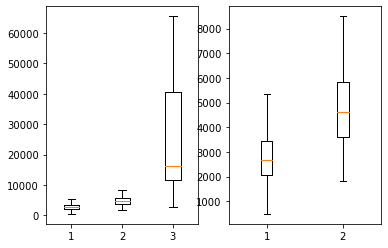

In [22]:
# With background subtraction
inner=3
outter = 11
means_mcp = fg_bg(mcp, inner=inner, outter=outter)
means_mcp_txn = fg_bg(mcp_txn, inner=inner, outter=outter)
means_rpb = fg_bg(rpb, inner=inner, outter=outter)
plt.subplot(121)
plt.boxplot([means_mcp, means_rpb, mcp_txn], showfliers=False);
plt.subplot(122)
plt.boxplot([means_mcp, means_rpb], showfliers=False);

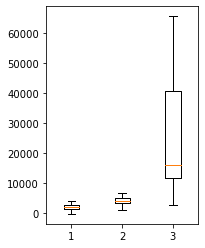

In [35]:
# With background subtraction
inner=5
outter = 9
means_mcp = fg_bg(mcp, inner=inner, outter=outter)
means_mcp_txn = fg_bg(mcp_txn, inner=inner, outter=outter)
means_rpb = fg_bg(rpb, inner=inner, outter=outter)
plt.subplot(121)
plt.boxplot([means_mcp, means_rpb, mcp_txn], showfliers=False);


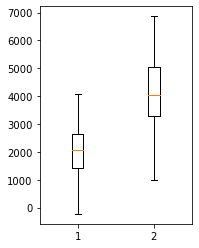

In [27]:
plt.subplot(122)
plt.boxplot([means_mcp, means_rpb], showfliers=False);

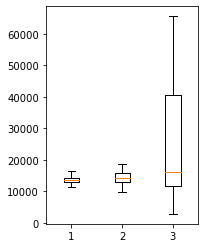

In [25]:
# Without background subtraction
inner=5
outter = 11
means_mcp = fg_bg(mcp, inner=inner, outter=outter, bg_subtract=False)
means_mcp_txn = fg_bg(mcp_txn, inner=inner, outter=outter, bg_subtract=False)
means_rpb = fg_bg(rpb, inner=inner, outter=outter, bg_subtract=False)
plt.subplot(121)
plt.boxplot([means_mcp, means_rpb, mcp_txn], showfliers=False);
plt.subplot(122)
plt.boxplot([means_mcp, means_rpb], showfliers=False);

In [16]:
%matplotlib inline
viewer([mcp_txn, mcp_txn2], figsize=6)

interactive(children=(Dropdown(description='Color', index=8, options=('gray', 'plasma', 'viridis', 'Gators', '…